# Jupyter Notebook for the running of DYNAMICAL

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Use GPU 1 for the operation


seed = 100

# 1) MUST do this before importing torch:
os.environ["PYTHONHASHSEED"]         = str(seed)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

All of the code that is present in this notebook are present in the other python files of this Dynamical folder

### Imports

In [2]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import pickle as pkl
import random
import shutil
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

### Dictionary that sets the model settings

In [3]:
model_settings ={
        "batch_size": 100,
        "epochs": 600,
        "lr": 3e-4,
        "nf": 64,
        "model": "gmn",
        "attention": 0,
        "n_layers": 4,
        "max_testing_samples": 600,
        "max_training_samples": 200,
        "data_dir": "/home/visharma/gnn/WORKING_DIR/2025_MASTER_STUDENTS/HUMAN_MOTION/data",
        "norm_diff": False,
        "weight_decay": 1e-10,
        "tanh": False,
        "learnable": False,
        "finite_diff":True,
        "time_step":1.0,
        "end_time_step": 30.0,
}

## Data

In [4]:
from scipy.signal import savgol_filter

In [8]:
class HumanDataset(torch.utils.data.Dataset):
    def __init__(self, partition='train', max_samples=600, data_dir='', nsteps=1):
        self.partition = partition
        self.data_dir = data_dir
        self.nsteps = nsteps

        # --- load raw data --------------------------------------
        with open(os.path.join(data_dir, 'motion.pkl'), 'rb') as f:
            edges, X = pkl.load(f)

        # your smoothing / central_diff code here...
        Ps, Vs, As = self.central_diff(X)

        # trial IDs must match exactly
        train_case_id = [20,1,17,13,14,9,4,2,7,5,16]
        val_case_id   = [3,8,11,12,15,18]
        test_case_id  = [6,19,21,0,22,10]

        # --- load or create competitor splits (fixed for central_diff) ----------
        split_path = os.path.join(data_dir, f'split_n{self.nsteps}.pkl')
        try:
            with open(split_path, 'rb') as f:
                train_mapping, val_mapping, test_mapping = pkl.load(f)
                print("Loaded competitor split!")
        except FileNotFoundError:
            print("Generating competitor split…")

            def make_map(case_ids):
                mapping = {}
                for i in case_ids:
                    core_len = Ps[i].shape[0]                    # <<— use length after central_diff
                    safe_max = core_len - self.nsteps*30 - 1
                    if safe_max < 0:
                        raise ValueError(f"Trial {i} too short for look-ahead of {self.nsteps} steps.")
                    # competitor caps at 300
                    itv = min(300, safe_max + 1)                # +1 because j in [0..safe_max]
                    pool = np.arange(itv)                       # j ∈ [0..itv-1]
                    mapping[i] = np.random.choice(pool, size=100, replace=False)
                return mapping

            train_mapping = make_map(train_case_id)
            val_mapping   = make_map(val_case_id)
            test_mapping  = make_map(test_case_id)

            with open(split_path, 'wb') as f:
                pkl.dump((train_mapping, val_mapping, test_mapping), f)
            print("Saved competitor split!")

        # pick the mapping you need
        if   partition == 'train': mapping = train_mapping
        elif partition == 'val'  : mapping = val_mapping
        elif partition == 'test' : mapping = test_mapping
        else: raise ValueError(f"Unknown partition {partition!r}")

        # now proceed exactly as before, using `mapping` instead of your make_mapping
        each_len = max_samples // len(mapping)
        in_graphs = []
        for i, pool in mapping.items():
            for j in pool[:each_len]:
                # note: they use delta_frame; you have nsteps*30, so this is identical
                cur_x_t   = Ps[i][j]
                cur_v_t   = Vs[i][j]
                cur_v_tm1 = Vs[i][j-1]
                y_dv      = Vs[i][j + self.nsteps*30] - Vs[i][j]
                y_dx      = Ps[i][j + self.nsteps*30] - Ps[i][j]
                y_pos_end = Ps[i][j + self.nsteps*30]
                y_vel_end = Vs[i][j + self.nsteps*30]

                in_graphs.append(self.create_in_graph(
                    edges,
                    x=(cur_x_t, cur_v_t, cur_v_tm1),
                    y=(y_dv, y_dx, y_pos_end, y_vel_end)
                ))

        self.in_graphs = in_graphs
        print(f"[HumanDataset:{partition}] built {len(in_graphs)} samples")

    def central_diff(self, Xs, dt: float = 1.0, window_length: int = 41):
        Ps, Vs, As = [], [], []
        for x in Xs:
            v      = (x[2:] - x[:-2]) / (2*dt)
            a      = (x[2:] - 2*x[1:-1] + x[:-2]) / (dt**2)
            p      = x[1:-1]                      # align to v,a
            Ps.append(p)
            Vs.append(v)
            As.append(a)
        return Ps, Vs, As

        
    def get_foot_nodes(self, nodes):
        foot_indices = np.argsort(nodes[:,1])[:6]
        foot_pos = nodes[foot_indices]
        return foot_pos, foot_indices
    
    def reflected_nodes(self, nodes, z0=0, epsilon=1e-3):
        reflected = nodes.copy()
        reflected[:,1] = 2*z0 - nodes[:,1] - epsilon
        distances = reflected[:,1] - nodes[:,1]
        return reflected, distances
    
    def find_min(self, nodes):
        return np.min(nodes, axis=0)
    

    def create_edges(self, N, edges):
        atom_edges = torch.zeros(N, N).int()
        for edge in edges:
            atom_edges[edge[0], edge[1]] = 1
            atom_edges[edge[1], edge[0]] = 1

        atom_edges2 = atom_edges @ atom_edges
        self.atom_edge = atom_edges
        self.atom_edge2 = atom_edges2
        edge_attr = []
        # Initialize edges and edge_attributes
        rows, cols = [], []
        for i in range(N):
            for j in range(N):
                if i != j:
                    if atom_edges[i][j]:
                        rows.append(i)
                        cols.append(j)
                        edge_attr.append([0])
                        assert not atom_edges2[i][j]
                    if atom_edges2[i][j]:
                        rows.append(i)
                        cols.append(j)
                        edge_attr.append([1])
                        assert not atom_edges[i][j]

        edges = [rows, cols] 
        edge_attr = torch.Tensor(np.array(edge_attr))  # [edge, 3]
        edge_idx =torch.tensor(edges, dtype=torch.long)  # [2, M]   
        return edge_idx,edge_attr     
    
    
    def create_in_graph(self, edges,x,y):
        pos_t, vel_t, vel_tm1 = x
        y_dv,y_dx,y_pos_end,y_vel_end = y

        edge_idx,edge_attr = self.create_edges(pos_t.shape[0], edges)

        # Get the ground node
        z0_t = self.find_min(pos_t)[1]

        # Get the foot node positions and indices
        foot_nodes_positions, foot_nodes_indices = self.get_foot_nodes(pos_t)
        foot_nodes_reflected, foot_distances = self.reflected_nodes(foot_nodes_positions,z0=z0_t)
        
        # Build reflected node indices
        current_largest_node_index = pos_t.shape[0]
        reflected_nodes_indices = list(range(current_largest_node_index,
                                             current_largest_node_index + len(foot_nodes_indices)))
        
        # Convert arrays to torch
        pos_t       = torch.tensor(pos_t, dtype=torch.float32)
        vel_t       = torch.tensor(vel_t, dtype=torch.float32)
        vel_tm1     = torch.tensor(vel_tm1, dtype=torch.float32)
        y_dv        = torch.tensor(y_dv, dtype=torch.float32)
        y_dx        = torch.tensor(y_dx, dtype=torch.float32)
        y_pos_end   = torch.tensor(y_pos_end, dtype=torch.float32)
        y_vel_end   = torch.tensor(y_vel_end, dtype=torch.float32)
        foot_nodes_reflected = torch.tensor(foot_nodes_reflected, dtype=torch.float32)
                
        # Node types: feet=1, reflections=2, others=0
        node_type = torch.zeros(pos_t.shape[0], 1)
        node_type[foot_nodes_indices] = 1
        new_node_type = torch.cat([
            node_type,
            2 * torch.ones(len(reflected_nodes_indices), 1)
        ], dim=0)
        
        # New bidirectional edges connecting each foot to its reflection
        # shape before transpose: [num_foot, 2]
        new_edges = torch.stack([
            torch.tensor(foot_nodes_indices,            dtype=torch.long),
            torch.tensor(reflected_nodes_indices,       dtype=torch.long),
        ], dim=0)  # [2, num_foot]
        rev_new_edges = new_edges.flip(0)
        new_edges_bidir = torch.cat([new_edges, rev_new_edges], dim=1)  # [2, 2*num_foot]

        # Combine with original edges
        full_edge_idx = torch.cat([edge_idx, new_edges_bidir], dim=1)
    
        # New edge attributes: all ones for these 1-hop reflections
        refl_attr = torch.zeros((new_edges_bidir.shape[1], 1))
        full_edge_attr = torch.cat([edge_attr, refl_attr], dim=0)

        # new edge attr for differentiating reflected nodes
        non_refl_edges = torch.zeros_like(edge_attr)
        refl_edges = torch.ones_like(refl_attr)
        new_edge_attr  = torch.cat([non_refl_edges, refl_edges], dim=0)

        full_edge_attr = torch.hstack((full_edge_attr, new_edge_attr))
        
        # Extend node features to include reflected nodes
        full_pos_t   = torch.cat([pos_t, foot_nodes_reflected], dim=0)
        full_vel_t   = torch.cat([vel_t, torch.zeros_like(foot_nodes_reflected)], dim=0)
        full_vel_tm1 = torch.cat([vel_tm1, torch.zeros_like(foot_nodes_reflected)], dim=0)
    
        in_graph = Data(edge_index=full_edge_idx, edge_attr=full_edge_attr)
        in_graph.pos       = full_pos_t
        in_graph.vel       = full_vel_t
        in_graph.prev_vel  = full_vel_tm1
        in_graph.y_dv       = y_dv
        in_graph.y_dx       = y_dx
        in_graph.end_pos   = y_pos_end
        in_graph.end_vel   = y_vel_end
        in_graph.node_type = new_node_type
    
        return in_graph   
        
    def __len__(self):
        return len(self.in_graphs)
    
    
    def __getitem__(self, index):
        return self.in_graphs[index]
    

In [9]:
dataset_train = HumanDataset(partition='train', max_samples=model_settings["max_training_samples"], data_dir=model_settings["data_dir"], nsteps=1)
dataset_test = HumanDataset(partition='test', max_samples=model_settings["max_testing_samples"], data_dir=model_settings["data_dir"], nsteps=1)
dataset_val = HumanDataset(partition='val', max_samples=model_settings["max_testing_samples"], data_dir=model_settings["data_dir"], nsteps=1)

Loaded competitor split!
[HumanDataset:train] built 198 samples
Loaded competitor split!
[HumanDataset:test] built 600 samples
Loaded competitor split!
[HumanDataset:val] built 600 samples


In [10]:
gt = next(iter(dataset_val))
# Convert to set of tuples
edges = set((i.item(), j.item()) for i, j in zip(gt.edge_index[0], gt.edge_index[1]))

# Check for missing reverse edges
missing = [(j, i) for (i, j) in edges if (j, i) not in edges]

if len(missing) == 0:
    print(" All edges are bidirectional.")
else:
    print(f"{len(missing)} edge(s) are not bidirectional:")
    print(missing[:10])  # print a few missing edges


 All edges are bidirectional.


The next cell creates the dataloaders

In [11]:
def create_graph_data(data):
    graph_current = data
    
    return graph_current

class GraphFromRawDataset(Dataset):
    def __init__(self, raw_dataset):
        self.raw_dataset = raw_dataset

    def __len__(self):
        return len(self.raw_dataset)

    def __getitem__(self, idx):
        data = self.raw_dataset[idx]
        return create_graph_data(data)

def create_dataloaders_from_raw(dataset, M, shuffle=True):
    """
    M: number of graphs to batch in training (use 1 for test/val)
    """
    # Wrap raw datasets into PyTorch Dataset
    dataset = GraphFromRawDataset(dataset)

    # Create dataloaders
    loader = DataLoader(dataset, batch_size=M, shuffle=shuffle, collate_fn=Batch.from_data_list)

    return loader


In [12]:
train_loader = create_dataloaders_from_raw(dataset_train,M=model_settings["batch_size"])
val_loader = create_dataloaders_from_raw(dataset_val,M=model_settings["batch_size"], shuffle=False)
test_loader = create_dataloaders_from_raw(dataset_test,M=model_settings["batch_size"], shuffle=False)

In [13]:
def calculate_min_max_edge(train_loader):
    """
    Calculate min/max statistics for graph properties using the ConsecutiveGraphDataset.
    
    Parameters:
    ----------
    timestep_dict : dict
        Dictionary containing graphs with keys as timesteps.
    time_step_increment : int, optional
        Time step increment to use (default: 1).
        
    Returns:
    -------
    tuple:
        Min/max statistics for various physical properties.
    """
    # Initialize lists to collect data
    all_edge_dx = []
    all_node_v_t = []
    all_node_v_tm1 = []
    all_node_dv = []
    all_node_dx = []
    
    # Process all valid timesteps
    for batch in train_loader:
        batched_graph = batch
        
        senders,receivers = batched_graph.edge_index

        edge_dx = batched_graph.pos[receivers] - batched_graph.pos[senders]
        
        # Extract positions and velocities
        node_vel_t = batched_graph.vel.float()
        node_vel_tm1 = batched_graph.prev_vel.float()
        
        # Calculate displacements and acceleration changes
        node_dv = (batched_graph.y_dv).float()
        node_dx = (batched_graph.y_dx).float()
        
        # Collect data
        all_edge_dx.append(edge_dx)
        all_node_v_t.append(node_vel_t)
        all_node_v_tm1.append(node_vel_tm1)
        all_node_dv.append(node_dv)
        all_node_dx.append(node_dx)
    
    # Concatenate all collected data
    all_edge_dx = torch.cat(all_edge_dx, dim=0)
    all_node_v_t = torch.cat(all_node_v_t, dim=0)
    all_node_v_tm1 = torch.cat(all_node_v_tm1, dim=0)
    all_node_dv= torch.cat(all_node_dv, dim=0)
    all_node_dx = torch.cat(all_node_dx,dim=0)
    
    # Compute norms
    norm_edge_dx = all_edge_dx.norm(dim=1)
    norm_node_v_t = all_node_v_t.norm(dim=1)
    norm_node_v_tm1 = all_node_v_tm1.norm(dim=1)
    norm_node_dv = all_node_dv.norm(dim=1)
    norm_node_dx = all_node_dx.norm(dim=1)
    
    # Compute min and max values of the norms
    min_edge_dx = norm_edge_dx.min()
    max_edge_dx = norm_edge_dx.max()

    min_node_v_t = norm_node_v_t.min()
    max_node_v_t = norm_node_v_t.max()

    min_node_v_tm1 = norm_node_v_tm1.min()
    max_node_v_tm1 = norm_node_v_tm1.max()

    mean_node_dv = norm_node_dv.mean()
    std_node_dv = norm_node_dv.std()

    mean_node_dx = norm_node_dx.mean()
    std_node_dx = norm_node_dx.std()

    # Collect statistics in tuples
    stat_edge_dx = (min_edge_dx, max_edge_dx)
    stat_node_v_t = (min_node_v_t, max_node_v_t)
    stat_node_v_tm1 = (min_node_v_tm1, max_node_v_tm1)
    stat_node_dv = (mean_node_dv, std_node_dv)
    stat_node_dx = (mean_node_dx, std_node_dx)
    
    return stat_edge_dx, stat_node_v_t, stat_node_dv, stat_node_dx

def move_train_stats_to_device(train_stats, device):
    def move_to_device(stat):
        if len(stat)==2:
            min_val, max_val = stat
            return min_val.to(device), max_val.to(device)
        else: 
            max_val = stat
            return max_val.to(device)
        

    return tuple(move_to_device(stat) for stat in train_stats)

## Dynamical Model

In [14]:
stats = calculate_min_max_edge(train_loader)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_stats = move_train_stats_to_device(stats, device)

### Components for the model

In [15]:
def build_mlp_d(in_size, hidden_size, out_size, num_layers=1, lay_norm=True, use_sigmoid=False, use_softmax=False):
    """
    Builds a multi-layer perceptron (MLP) with configurable depth and optional layer normalization and sigmoid or softmax activation.

    Args:
        in_size (int): The size of the input feature vector.
        hidden_size (int): The size of the hidden layers.
        out_size (int): The size of the output layer.
        num_layers (int): The number of layers in the MLP.
        lay_norm (bool): Flag to add layer normalization after the last linear layer.
        use_sigmoid (bool): Flag to add a sigmoid activation layer at the output.
        use_softmax (bool): Flag to add a softmax activation layer at the output.

    Returns:
        nn.Module: The constructed MLP model.

    Raises:
        ValueError: If both use_sigmoid and use_softmax are True.
    """
    if use_sigmoid and use_softmax:
        raise ValueError("Only one of use_sigmoid or use_softmax can be true.")
    layers = [nn.Linear(in_size, hidden_size), nn.ReLU()]
    
    # Add intermediate layers
    for _ in range(num_layers - 1):
        layers.append(nn.Linear(hidden_size, hidden_size))
        layers.append(nn.ReLU())

    # Add the output layer
    layers.append(nn.Linear(hidden_size, out_size))

    # Create the MLP module
    module = nn.Sequential(*layers)

    # Optionally add layer normalization
    if lay_norm:
        module = nn.Sequential(module, nn.LayerNorm(normalized_shape=out_size))

    # Optionally add sigmoid activation
    if use_sigmoid:
        module = nn.Sequential(module, nn.Sigmoid())

    # Optionally add softmax activation
    if use_softmax:
        module = nn.Sequential(module, nn.Softmax(dim=-1))

    return module


In [16]:
class RefFrameCalc(nn.Module):
    def __init__(self):
        super(RefFrameCalc, self).__init__()

    def forward(self, edge_index,senders_pos,receivers_pos, senders_vel,receivers_vel, senders_omega, receivers_omega):
        
        senders, receivers = edge_index

        epsilon = 1e-8

        vector_a = (receivers_pos - senders_pos)/ torch.clamp((receivers_pos - senders_pos).norm(dim=1, keepdim=True), min=epsilon)

        #prelimnary vectors
        b_a = torch.cross(receivers_vel-senders_vel,vector_a)
        b_a = b_a / torch.clamp(b_a.norm(dim=1, keepdim=True), min=epsilon)
        b_c = (senders_vel + receivers_vel)
        b_c = b_c / torch.clamp(b_c.norm(dim=1, keepdim=True), min=epsilon)
        
        b_a_ = torch.cross(receivers_omega-senders_omega,vector_a)
        b_a_ = b_a_ / torch.clamp(b_a_.norm(dim=1, keepdim=True), min=epsilon)
        b_c_ = (senders_omega + receivers_omega)
        b_c_ = b_c_ / torch.clamp(b_c_.norm(dim=1, keepdim=True), min=epsilon)

        b = b_a + b_c + b_a_ + b_c_ 

        # Compute the parallel component of b
        b_prl_dot = torch.einsum('ij,ij->i', b, vector_a).unsqueeze(1)
        b_prl = b_prl_dot * vector_a

        # Compute the perpendicular component of b
        b_prp = b - b_prl

        vector_b = torch.cross(b_prp, vector_a) #perp to a and a new vector b_prp
        vector_c = torch.cross(b_prl, vector_b) #perp to a and b
        
        vector_b = vector_b / torch.clamp(vector_b.norm(dim=1, keepdim=True), min=epsilon)
        vector_c = vector_c / torch.clamp(vector_c.norm(dim=1, keepdim=True), min=epsilon)
   
        return vector_a, vector_b, vector_c
    

In [17]:
class NodeEncoder(nn.Module):
    def __init__(self, latent_size):
        super(NodeEncoder, self).__init__()
        self.node_encoder = build_mlp_d(2, latent_size, latent_size, num_layers=2, lay_norm=True)
    def forward(self,node_scalar_feat):
        node_latent = self.node_encoder(node_scalar_feat)  
        return node_latent

In [18]:
class InteractionEncoder(nn.Module):
    """Message passing."""

    def __init__(self, latent_size):
        super(InteractionEncoder, self).__init__()
        self.edge_feat_encoder = build_mlp_d(12, latent_size, latent_size, num_layers=2, lay_norm=True)
        self.edge_encoder = build_mlp_d(3, latent_size, latent_size, num_layers=2, lay_norm=True)
        self.interaction_encoder = build_mlp_d(3*latent_size,latent_size, latent_size, num_layers=2, lay_norm=True)
    def forward(self, edge_index, edge_dx_,edge_attr, vector_a, vector_b, vector_c,
                senders_v_t_, senders_v_tm1_, senders_w_t_,senders_th_t_,
                receivers_v_t_, receivers_v_tm1_, receivers_w_t_,receivers_th_t_,
                node_latent):

        senders, receivers = edge_index

        node_v_t_senders_a = torch.einsum('ij,ij->i', senders_v_t_, vector_a).unsqueeze(1)
        node_v_t_senders_b = torch.einsum('ij,ij->i', senders_v_t_, vector_b).unsqueeze(1)
        node_v_t_senders_c = torch.einsum('ij,ij->i', senders_v_t_, vector_c).unsqueeze(1)

        node_v_tm1_senders_a = torch.einsum('ij,ij->i', senders_v_tm1_, vector_a).unsqueeze(1)
        node_v_tm1_senders_b = torch.einsum('ij,ij->i', senders_v_tm1_, vector_b).unsqueeze(1)
        node_v_tm1_senders_c = torch.einsum('ij,ij->i', senders_v_tm1_, vector_c).unsqueeze(1)    

        node_w_t_senders_a = torch.einsum('ij,ij->i', senders_w_t_, vector_a).unsqueeze(1)
        node_w_t_senders_b = torch.einsum('ij,ij->i', senders_w_t_, vector_b).unsqueeze(1)
        node_w_t_senders_c = torch.einsum('ij,ij->i', senders_w_t_, vector_c).unsqueeze(1)
        
        node_th_t_senders_a = torch.einsum('ij,ij->i', senders_th_t_, vector_a).unsqueeze(1)
        node_th_t_senders_b = torch.einsum('ij,ij->i', senders_th_t_, vector_b).unsqueeze(1)
        node_th_t_senders_c = torch.einsum('ij,ij->i', senders_th_t_, vector_c).unsqueeze(1)   
        
        node_v_t_receivers_a = torch.einsum('ij,ij->i', receivers_v_t_, -vector_a).unsqueeze(1)
        node_v_t_receivers_b = torch.einsum('ij,ij->i', receivers_v_t_, -vector_b).unsqueeze(1)
        node_v_t_receivers_c = torch.einsum('ij,ij->i', receivers_v_t_, -vector_c).unsqueeze(1)

        node_v_tm1_receivers_a = torch.einsum('ij,ij->i',receivers_v_tm1_, -vector_a).unsqueeze(1)
        node_v_tm1_receivers_b = torch.einsum('ij,ij->i',receivers_v_tm1_, -vector_b).unsqueeze(1)
        node_v_tm1_receivers_c = torch.einsum('ij,ij->i',receivers_v_tm1_, -vector_c).unsqueeze(1)       
        
        node_w_t_receivers_a = torch.einsum('ij,ij->i', receivers_w_t_, -vector_a).unsqueeze(1)
        node_w_t_receivers_b = torch.einsum('ij,ij->i', receivers_w_t_, -vector_b).unsqueeze(1)
        node_w_t_receivers_c = torch.einsum('ij,ij->i', receivers_w_t_, -vector_c).unsqueeze(1)

        node_th_t_receivers_a = torch.einsum('ij,ij->i', receivers_th_t_, -vector_a).unsqueeze(1)
        node_th_t_receivers_b = torch.einsum('ij,ij->i', receivers_th_t_, -vector_b).unsqueeze(1)
        node_th_t_receivers_c = torch.einsum('ij,ij->i', receivers_th_t_, -vector_c).unsqueeze(1)
        
        edge_dx_a_s = edge_dx_.norm(dim=1,keepdim=True)

        senders_features = torch.hstack((
            node_v_t_senders_a, node_v_t_senders_b, node_v_t_senders_c,
            node_v_tm1_senders_a, node_v_tm1_senders_b, node_v_tm1_senders_c,
            node_w_t_senders_a, node_w_t_senders_b, node_w_t_senders_c,
            node_th_t_senders_a, node_th_t_senders_b, node_th_t_senders_c
        ))

        receivers_features = torch.hstack((
            node_v_t_receivers_a, node_v_t_receivers_b, node_v_t_receivers_c,
            node_v_tm1_receivers_a, node_v_tm1_receivers_b, node_v_tm1_receivers_c,
            node_w_t_receivers_a, node_w_t_receivers_b, node_w_t_receivers_c,
            node_th_t_receivers_a, node_th_t_receivers_b, node_th_t_receivers_c
        ))
        
        edge_latent = self.edge_encoder(torch.hstack((edge_dx_a_s, edge_attr)))

        senders_latent = self.edge_feat_encoder(senders_features)
        receivers_latent = self.edge_feat_encoder(receivers_features)

        interaction_latent = self.interaction_encoder(torch.hstack((senders_latent + receivers_latent,
                                                                    node_latent[senders]+node_latent[receivers],
                                                                    edge_latent)))

        return interaction_latent

In [19]:
class InteractionDecoder(torch.nn.Module):

    def __init__(self, latent_size=128):
        super(InteractionDecoder, self).__init__()
        self.i1_decoder = build_mlp_d(latent_size, latent_size, 3, num_layers=2, lay_norm=False)
        self.i2_decoder = build_mlp_d(latent_size, latent_size, 3, num_layers=2, lay_norm=False)

    def forward(self, edge_index, senders_pos, receivers_pos, vector_a, vector_b, vector_c, interaction_latent, node_latent):
        senders, receivers = edge_index

        coeff_f = self.i1_decoder(interaction_latent)
        coeff_t = self.i2_decoder(interaction_latent)

        fij = (coeff_f[:, 0:1] * vector_a + 
              coeff_f[:, 1:2] * vector_b + 
              coeff_f[:, 2:] * vector_c)
        
        
        tij = (coeff_t[:, 0:1] * vector_a + 
              coeff_t[:, 1:2] * vector_b + 
              coeff_t[:, 2:] * vector_c)        
        return fij, tij


In [20]:
class Node_Internal_Dv_Decoder(torch.nn.Module):
    def __init__(self, latent_size=128):
        super(Node_Internal_Dv_Decoder, self).__init__()
        self.m_inv_decoder = build_mlp_d(latent_size, latent_size, 1, num_layers=2, lay_norm=False)
        self.i_inv_decoder = build_mlp_d(latent_size, latent_size, 1, num_layers=2, lay_norm=False)
        self.f_ext_dv_decoder = build_mlp_d(latent_size, latent_size, 1, num_layers=2, lay_norm=False)
    def forward(self,edge_index,node_latent,fij,tij):
        m_inv = self.m_inv_decoder(node_latent) # decode inverse of mass
        i_inv = self.i_inv_decoder(node_latent) # decode inverse of inertia
        senders,receivers = edge_index   
        
        out_fij = torch.zeros((node_latent.shape[0], fij.shape[1])).to(device)
        out_fij = out_fij.scatter_add(0, receivers.unsqueeze(1).expand(-1, fij.shape[1]).to(device), fij.to(device))
        node_dv_int = m_inv * out_fij + self.f_ext_dv_decoder(node_latent)
        
        out_tij = torch.zeros((node_latent.shape[0], fij.shape[1])).to(device)
        out_tij = out_tij.scatter_add(0, receivers.unsqueeze(1).expand(-1, fij.shape[1]).to(device), tij.to(device))
        node_dw_int = i_inv * out_tij       

        return node_dv_int, node_dw_int


In [21]:
class Scaler(torch.nn.Module):
    def __init__(self):
        super(Scaler, self).__init__()
        '''
        Scales the velocity and angular velocity features by maximum magnitude of respective field in training data
        Scales the magnitude of the edge_vector_dx using min-max scaling. (keeping the direction of edge_vector_dx same)
        '''

    def forward(self, senders_v_t, senders_v_tm1,receivers_v_t, receivers_v_tm1,edge_dx,train_stats):
        stat_edge_dx, stat_node_v_t, _,_= train_stats
        
        senders_v_t_ = senders_v_t/stat_node_v_t[1].detach()
        senders_v_tm1_ = senders_v_tm1/stat_node_v_t[1].detach()
        receivers_v_t_ = receivers_v_t/stat_node_v_t[1].detach()
        receivers_v_tm1_ = receivers_v_tm1/stat_node_v_t[1].detach()
        norm_edge_dx = edge_dx.norm(dim=1, keepdim=True)
        edge_dx_ = (((norm_edge_dx-stat_edge_dx[0])/(stat_edge_dx[1]-stat_edge_dx[0]))*(edge_dx/norm_edge_dx)).detach()
        return senders_v_t_, senders_v_tm1_,receivers_v_t_, receivers_v_tm1_,edge_dx_


In [22]:
class Interaction_Block(torch.nn.Module):
    def __init__(self, latent_size):
        super(Interaction_Block, self).__init__()
        self.interaction_encoder = InteractionEncoder(latent_size)
        self.interaction_decoder = InteractionDecoder(latent_size)
        self.internal_dv_decoder = Node_Internal_Dv_Decoder(latent_size)
        self.layer_norm = nn.LayerNorm(latent_size)

    def forward(self, edge_index, senders_pos, receivers_pos, edge_dx_, edge_attr,vector_a, vector_b, vector_c, 
                senders_v_t_, senders_v_tm1_, senders_w_t_,senders_th_t_,
                receivers_v_t_, receivers_v_tm1_, receivers_w_t_,receivers_th_t_,
                node_latent, residue=None, latent_history=False):
            interaction_latent = self.interaction_encoder(edge_index, edge_dx_,edge_attr,
                                                          vector_a, vector_b, vector_c,
                                                          senders_v_t_, senders_v_tm1_, senders_w_t_,senders_th_t_,
                                                          receivers_v_t_, receivers_v_tm1_, receivers_w_t_,receivers_th_t_,
                                                          node_latent)

            if latent_history:
                interaction_latent = interaction_latent + residue
                interaction_latent = self.layer_norm(interaction_latent)
            
            edge_interaction_force, edge_interaction_tau= self.interaction_decoder(
                edge_index, senders_pos, receivers_pos, vector_a, vector_b, vector_c, interaction_latent, node_latent
            )
            node_dv_int_decoded, node_dw_int_decoded = self.internal_dv_decoder(
                edge_index, node_latent, edge_interaction_force, edge_interaction_tau
            )
        
            return node_dv_int_decoded, node_dw_int_decoded, interaction_latent


In [54]:
class DynamicsSolver(torch.nn.Module):
    def __init__(self, sample_step, train_stats, num_jumps=1, num_msgs=1, latent_size=128):
        super(DynamicsSolver, self).__init__()
        self.refframecalc = RefFrameCalc()
        self.scaler = Scaler()
        self.node_encoder = NodeEncoder(latent_size)
        self.interaction_proc_layer = Interaction_Block(latent_size)
        self.interaction_init_layer = Interaction_Block(latent_size)
        self.num_messages = num_msgs
        self.sub_tstep = sample_step / num_msgs
        self.train_stats = train_stats

    def forward(self, graph):
        # Initialize graph data for processing
        device = graph.pos.device
        graph = graph.to(device)
        node_type = graph.node_type.float()
        pos = graph.pos.float()
        vel = graph.vel.float()
        prev_vel = graph.prev_vel.float()
        
        edge_index = graph.edge_index.long()
        senders, receivers = edge_index
        senders_pos = pos[senders]
        receivers_pos = pos[receivers]
        edge_dx = receivers_pos - senders_pos
        edge_attr = graph.edge_attr.float()
        
        mask_non_refl = (graph.node_type!=2).squeeze()

        node_v_t = vel
        node_w_t = getattr(graph, 'node_w_t',torch.zeros_like(node_v_t))
        node_th_t = getattr(graph, 'node_th_t', torch.zeros_like(node_v_t))

        senders_v_t = node_v_t[senders].float()
        receivers_v_t = node_v_t[receivers].float()

        senders_v_tm1 = prev_vel[senders].float()
        receivers_v_tm1 = prev_vel[receivers].float()

        senders_w_t = node_w_t[senders]
        receivers_w_t = node_w_t[receivers]
        
        senders_th_t = node_th_t[senders]
        receivers_th_t = node_th_t[receivers]        

        node_disp = torch.zeros_like(node_v_t)
        node_vf = torch.zeros_like(node_v_t)
        node_wf = torch.zeros_like(node_v_t)

        sum_node_dv = torch.zeros_like(node_v_t)
        sum_node_dx = torch.zeros_like(node_v_t)
        
        node_latent = self.node_encoder(torch.hstack((node_type,pos[:,1:2])))


        for i in range(self.num_messages):
            (
                senders_v_t_,
                senders_v_tm1_,
                receivers_v_t_,
                receivers_v_tm1_,
                edge_dx_,
            ) = self.scaler(
                senders_v_t,
                senders_v_tm1,
                receivers_v_t,
                receivers_v_tm1,
                edge_dx,
                self.train_stats,
            )


            vector_a, vector_b, vector_c = self.refframecalc(
                    edge_index,
                    senders_pos,
                    receivers_pos,
                    senders_v_t_,
                    receivers_v_t_,
                    senders_w_t,
                    receivers_w_t
                    
                )

            if i == 0:
                node_dv_int_decoded, node_dw_int_decoded,residue= self.interaction_init_layer(
                    edge_index,
                    senders_pos,
                    receivers_pos,
                    edge_dx_,
                    edge_attr,
                    vector_a,
                    vector_b,
                    vector_c,
                    senders_v_t_,
                    senders_v_tm1_,
                    senders_w_t,
                    senders_th_t,
                    receivers_v_t_,
                    receivers_v_tm1_,
                    receivers_w_t,
                    receivers_th_t,
                    node_latent,
                    latent_history=False,
                )
            else:
                node_dv_int_decoded, node_dw_int_decoded, residue = self.interaction_proc_layer(
                    edge_index,
                    senders_pos,
                    receivers_pos,
                    edge_dx_,
                    edge_attr,
                    vector_a,
                    vector_b,
                    vector_c,
                    senders_v_t_,
                    senders_v_tm1_,
                    senders_w_t,
                    senders_th_t,
                    receivers_v_t_,
                    receivers_v_tm1_,
                    receivers_w_t,
                    receivers_th_t,
                    node_latent,
                    residue=residue,
                    latent_history=True,
                )

            sum_node_dv [mask_non_refl]= sum_node_dv [mask_non_refl] + node_dv_int_decoded[mask_non_refl]
                
            node_vf[mask_non_refl]= node_v_t[mask_non_refl] + node_dv_int_decoded[mask_non_refl]
            node_wf[mask_non_refl]= node_w_t[mask_non_refl] + node_dw_int_decoded[mask_non_refl]

            node_disp= (
                (node_v_t + node_vf) * 0.5 * self.sub_tstep
            )

            node_th_t = node_th_t + (node_wf + node_w_t)* 0.5 * self.sub_tstep

            sum_node_dx [mask_non_refl]=sum_node_dx [mask_non_refl]+ ((node_v_t + node_vf) * 0.5 * self.sub_tstep)[mask_non_refl]

            senders_disp = node_disp[senders]
            receivers_disp = node_disp[receivers]

            senders_pos = senders_disp + senders_pos
            receivers_pos = receivers_disp + receivers_pos

            node_v_tm1 = node_v_t.clone()

            node_v_t = node_vf.clone()
            node_w_t = node_wf.clone()

            senders_v_tm1 = senders_v_t.clone()
            senders_v_t = node_v_t[senders].clone()
            senders_w_t = node_w_t[senders].clone()
            senders_th_t = node_th_t[senders].clone()

            receivers_v_tm1 = receivers_v_t.clone()
            receivers_v_t = node_v_t[receivers].clone()
            receivers_w_t = node_w_t[receivers].clone()
            receivers_th_t = node_th_t[receivers].clone()

            edge_dx = receivers_pos - senders_pos
        return sum_node_dv[mask_non_refl],sum_node_dx[mask_non_refl],node_v_tm1

In [55]:
def evaluate(test_loader, model, device, mode='test', plot=False, frequency=1, model_name='PIGNN', experiment_name='Val'):
    with torch.no_grad():
        res = 0.
        res_counter = 0

        for test_batch in test_loader:
            for i in range(1):  # Iterates 10 times: 0 -> predicts 31, ..., 9 -> predicts 40
                if i == 0:
                    graph_t0 = test_batch.to(device)
                    # Clone to ensure ground truth remains unchanged
                    end_pos = graph_t0.end_pos.clone()  
                    mask_non_refl = (graph_t0.node_type!=2).squeeze()
                new_vel = torch.zeros_like(graph_t0.vel)
                new_pos = graph_t0.pos
                node_dv,node_dx,_= model(graph_t0.detach())
                new_vel[mask_non_refl] =  graph_t0.vel[mask_non_refl] + node_dv
                new_pos[mask_non_refl] =  graph_t0.pos[mask_non_refl] + node_dx

                graph_t0.prev_pos = graph_t0.pos.clone()
                graph_t0.prev_vel = graph_t0.vel.clone()
                graph_t0.pos = new_pos.clone()
                graph_t0.vel = new_vel.clone()

            loss = F.mse_loss(new_pos[mask_non_refl], end_pos)
            batch_size = graph_t0.num_graphs
            res += loss.item() * batch_size
            res_counter += batch_size

        mean_pos_error = res / res_counter
    return mean_pos_error

In [56]:
class Trainer:
    def __init__(self, model, optimizer, device, train_stats):
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.train_history = []
        self.extr_test_history = []
        self.gen_test_history = []
        self.cur_dir = os.getcwd()
        self.model_dir = os.path.join(self.cur_dir, 'saved_models')
        self.gen_loss = 0.
        self.train_stats = train_stats
        self.mean_node_dv = self.train_stats[2][0]
        self.mean_node_disp = self.train_stats[3][0]
        self.std_node_dv = self.train_stats[2][1]
        self.std_node_disp = self.train_stats[3][1]
        # Initialize best test loss and best epoch.
        self.best_val_loss = float('inf')
        self.best_epoch = None        

    def train(self, train_graph):
        self.model.train()
        pred_node_dvel,pred_node_disp,_ = self.model(train_graph.to(self.device))

        actual_node_dvel = (train_graph.y_dv).float().to(self.device)
        actual_node_disp = (train_graph.y_dx).float().to(self.device)

        pred_node_dvel_ = (pred_node_dvel-self.mean_node_dv.detach())/self.std_node_dv.detach()
        pred_node_disp_ = (pred_node_disp-self.mean_node_disp.detach())/self.std_node_disp.detach()
        actual_node_dvel_ = (actual_node_dvel - self.mean_node_dv.detach())/self.std_node_dv.detach()
        actual_node_disp_ = (actual_node_disp-self.mean_node_disp.detach())/self.std_node_disp.detach()

        loss = F.mse_loss(pred_node_disp_,actual_node_disp_) + F.mse_loss(pred_node_dvel_,actual_node_dvel_)
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.optimizer.step()

        self.loss = loss.cpu().detach().numpy()
        self.train_history.append(self.loss)
    def test(self, test_loader, mode='val', epoch=None):
        self.model.eval()
        mean_pos_error = evaluate(test_loader,
                            self.model,
                            self.device)
        
        
        if mode == 'val':
            self.val_loss_pos = mean_pos_error
            self.gen_test_history.append(self.val_loss_pos)
            # Update best test loss and best epoch if the current loss is lower
            if epoch is not None and self.val_loss_pos < self.best_val_loss:
                self.best_val_loss = self.val_loss_pos
                self.best_epoch = epoch
                self.save_model(epoch)
        if mode == 'test':
            self.test_loss_pos = mean_pos_error

    def save_model(self,iteration):
        if not os.path.exists(self.model_dir):
            os.makedirs(self.model_dir)
        self.path = os.path.join(self.model_dir, 
                                 f'GenLoss_{self.val_loss_pos:.5f}mm_iter{iteration}.pth')
        torch.save(self.model.state_dict(), self.path)

In [57]:
if model_settings["finite_diff"]:
    SAMPLE_TIME_STEP = 30*model_settings["time_step"]
else:
    SAMPLE_TIME_STEP = 30*model_settings["time_step_actual"]
print(f'SAMPLE_TIME_STEP = ',SAMPLE_TIME_STEP)
N= 1
MODEL = DynamicsSolver(SAMPLE_TIME_STEP, train_stats, num_jumps=N, num_msgs=5, latent_size=64)
optimizer = torch.optim.Adam(MODEL.parameters(), lr = 5e-4)
print(f"Using {device} device")

def ensure_model_on_device(model, device):
    for module in model.modules():
        # Check if any parameter of the module is not on the desired device
        if any(p.device != device for p in module.parameters()):
            # Move the entire module to the device
            module.to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ensure_model_on_device(MODEL, device)

SAMPLE_TIME_STEP =  30.0
Using cuda device


In [58]:
trainer = Trainer(MODEL, 
                  optimizer, 
                  device,
                  train_stats
                 )
# Clear PyTorch CUDA cache
torch.cuda.empty_cache()

In [46]:
from tqdm import tqdm

epochs = 2300

# initialize to large values
val_loss = np.inf
test_loss = np.inf

# wrap the epoch loop in tqdm
with tqdm(range(1, epochs+1), desc='Training') as pbar:
    for epoch in pbar:
        # ——— Training ———
        for train_batch in train_loader:
            trainer.train(train_batch)

        # ——— Validation & Test ———
        # trainer.test now returns the mean positional error
        if epoch%5==0:
            trainer.test(val_loader,  mode='val',  epoch=epoch)
            val_loss = trainer.val_loss_pos
            trainer.test(test_loader, mode='test')
            test_loss = trainer.test_loss_pos

        # ——— Learning rate ———
        current_lr = trainer.optimizer.param_groups[0]['lr']

        # ——— Update the progress bar ———
        pbar.set_postfix({
            'TrainLoss (*1e3)': f'{trainer.loss * 1e3:.5e}',
            'ValLoss':           f'{val_loss:.8e}',
            'BestVal':           f'{trainer.best_val_loss:.5e}(Ep{trainer.best_epoch})',
            'TestLoss':          f'{test_loss:.8e}',
            'LR':                f'{current_lr:.2e}',
        })


Training:  73%|███████▎  | 1680/2300 [25:09<09:17,  1.11it/s, TrainLoss (*1e3)=4.07719e+01, ValLoss=2.48670158e-01, BestVal=2.27041e-01(Ep1595), TestLoss=1.93546104e-01, LR=5.00e-04]


KeyboardInterrupt: 

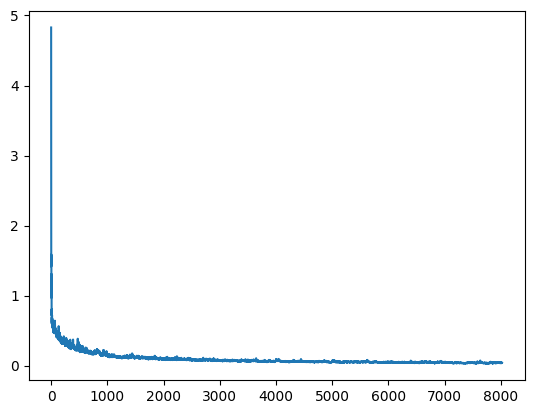

In [47]:
plt.plot(trainer.train_history)

## Rollout

This next cell has the functions that will, given a frame of the human, use the model to predict eventual position of the human after 30 time steps. It then also gives some sample animations of the predictions alongside the ground truth of the final position.

### Main loop that runs the test rollout

In [59]:
import re
# Regular expression pattern to extract loss and epoch
pattern = r'GenLoss_(\d+\.\d+)mm_iter(\d+)\.pth'

best_loss = float('inf')
best_epoch = None
best_file = None
for fn in os.listdir(trainer.model_dir):
    m = re.search(pattern, fn)
    if m:
        l = float(m.group(1))
        if l < best_loss:
            best_loss = l
            best_epoch = int(m.group(2))
            best_file = fn

if best_file is None:
    raise RuntimeError("No checkpoint found!")
path = os.path.join(trainer.model_dir, best_file)
trainer.model.load_state_dict(torch.load(path))
# Print the best result in the desired format.
print(f'Best file: {best_file}')

Best file: GenLoss_0.22704mm_iter1595.pth


In [60]:
trainer.model.eval()
trainer.test(val_loader, mode='val')
print(trainer.val_loss_pos)

0.22704078753789267


In [61]:
trainer.model.eval()
trainer.test(test_loader, mode='val')
print(trainer.val_loss_pos)

0.17131339510281882


In [62]:
def reflected_nodes_eval(nodes, z0=0.0, epsilon=1e-3):
    # nodes: torch.Tensor [n,3]
    reflected = nodes.clone()
    reflected[:,1] = 2*z0 - nodes[:,1] - epsilon
    distances = reflected[:,1] - nodes[:,1]
    return reflected, distances

def find_min(nodes):
    return torch.tensor(np.min(nodes[:,1:2].detach().cpu().numpy(), axis=0)).to(nodes.device)


def evaluate_rollout(test_loader, model, device, nsteps=1):
    model.eval()
    with torch.no_grad():
        res = 0.
        res_counter = 0

        for test_batch in test_loader:
            for i in range(nsteps):  # Iterates 10 times: 0 -> predicts 31, ..., 9 -> predicts 40
                if i == 0:
                    test_graph = test_batch.to(device)
                    graph_t0 = test_graph
                    # Clone to ensure ground truth remains unchanged
                    end_pos = test_graph.end_pos.clone()  
                    mask_foot = (graph_t0.node_type==1).squeeze()
                    mask_refl = (graph_t0.node_type==2).squeeze()
                    mask_non_refl = (graph_t0.node_type!=2).squeeze()

                    zmin_0 = find_min(graph_t0.pos[mask_non_refl])
                    
                node_dv,node_dx,vm1= model(graph_t0.detach())
                new_vel_body =  graph_t0.vel[mask_non_refl] + node_dv
                new_pos_body =  graph_t0.pos[mask_non_refl] + node_dx
                
                # Get the foot node positions and indices
                new_pos_full = torch.zeros_like(graph_t0.pos)
                new_pos_full[mask_non_refl] = new_pos_body#_centered
                new_foot_pos = new_pos_full[mask_foot]
                zmin_t = find_min(new_pos_body)
                new_foot_ref_pos, _ = reflected_nodes_eval(new_foot_pos,zmin_t) 

                graph_t0.prev_pos = graph_t0.pos.clone()
                graph_t0.prev_vel = vm1
                
                graph_t0.pos[mask_non_refl] = new_pos_body#_centered
                graph_t0.pos[mask_refl] = new_foot_ref_pos
                graph_t0.vel[mask_non_refl] = new_vel_body.clone()
                graph_t0.vel[mask_refl] = graph_t0.vel[mask_refl]*0.0

            loss = F.mse_loss(new_pos_body, end_pos)
            batch_size = test_graph.num_graphs
            res += loss.item() * batch_size
            res_counter += batch_size

        mean_pos_error = res / res_counter
    return mean_pos_error

In [63]:

for nstep in [1,2,3,4]:
    
    dataset_eval = HumanDataset(partition='test', max_samples=model_settings["max_testing_samples"], data_dir=model_settings["data_dir"],nsteps=nstep)
    
    dataloader_eval = create_dataloaders_from_raw(dataset_eval,200,shuffle=False)
    
    eval_error = evaluate_rollout(dataloader_eval, trainer.model, device, nsteps=nstep)
    
    print(f'loss for rollout {nstep} steps {eval_error}')

Loaded competitor split!
[HumanDataset:test] built 600 samples
loss for rollout 1 steps 0.17131340503692627
Loaded competitor split!
[HumanDataset:test] built 600 samples
loss for rollout 2 steps 1.1794992685317993
Loaded competitor split!
[HumanDataset:test] built 600 samples
loss for rollout 3 steps 2.986961603164673
Loaded competitor split!
[HumanDataset:test] built 600 samples
loss for rollout 4 steps 7.442751407623291


# visualization

In [64]:
class HumanDatasetSeq(torch.utils.data.Dataset):
    def __init__(self, partition='train', max_samples=600, data_dir='', nsteps=1):
        self.partition = partition
        self.data_dir = data_dir
        self.nsteps = nsteps

        # --- load raw data --------------------------------------
        with open(os.path.join(data_dir, 'motion.pkl'), 'rb') as f:
            edges, X = pkl.load(f)

        # your smoothing / central_diff code here...
        Ps, Vs, As = self.central_diff(X)

        # trial IDs must match exactly
        train_case_id = [20,1,17,13,14,9,4,2,7,5,16]
        val_case_id   = [3,8,11,12,15,18]
        test_case_id  = [6,19,21,0,22,10]

        # --- load or create competitor splits (fixed for central_diff) ----------
        split_path = os.path.join(data_dir, f'split_n{self.nsteps}.pkl')
        try:
            with open(split_path, 'rb') as f:
                train_mapping, val_mapping, test_mapping = pkl.load(f)
                print("Loaded competitor split!")
        except FileNotFoundError:
            print("Generating competitor split…")

            def make_map(case_ids):
                mapping = {}
                for i in case_ids:
                    core_len = Ps[i].shape[0]                    # <<— use length after central_diff
                    safe_max = core_len - self.nsteps*30 - 1
                    if safe_max < 0:
                        raise ValueError(f"Trial {i} too short for look-ahead of {self.nsteps} steps.")
                    # competitor caps at 300
                    itv = min(300, safe_max + 1)                # +1 because j in [0..safe_max]
                    pool = np.arange(itv)                       # j ∈ [0..itv-1]
                    mapping[i] = np.random.choice(pool, size=100, replace=False)
                return mapping

            train_mapping = make_map(train_case_id)
            val_mapping   = make_map(val_case_id)
            test_mapping  = make_map(test_case_id)

            with open(split_path, 'wb') as f:
                pkl.dump((train_mapping, val_mapping, test_mapping), f)
            print("Saved competitor split!")

        # pick the mapping you need
        if   partition == 'train': mapping = train_mapping
        elif partition == 'val'  : mapping = val_mapping
        elif partition == 'test' : mapping = test_mapping
        else: raise ValueError(f"Unknown partition {partition!r}")

        # now proceed exactly as before, using `mapping` instead of your make_mapping
        each_len = max_samples // len(mapping)
        in_graphs = []
        for i, pool in mapping.items():
            for j in pool[:each_len]:
                # note: they use delta_frame; you have nsteps*30, so this is identical
                cur_x_t   = Ps[i][j]
                cur_v_t   = Vs[i][j]
                cur_v_tm1 = Vs[i][j-1]
                y_dv      = Vs[i][j + self.nsteps*30] - Vs[i][j]
                y_dx      = Ps[i][j + self.nsteps*30] - Ps[i][j]
                gt_seq = [ Ps[i][j + k*30] for k in range(self.nsteps+1) ]   # list of (31,3) arrays
                y_pos_end = Ps[i][j + self.nsteps*30]
                y_vel_end = Vs[i][j + self.nsteps*30]

                in_graphs.append(self.create_in_graph(
                    edges,
                    x=(cur_x_t, cur_v_t, cur_v_tm1),
                    y=(y_dv, y_dx, y_pos_end, y_vel_end),
                    gt_seq = gt_seq
                ))

        self.in_graphs = in_graphs
        print(f"[HumanDataset:{partition}] built {len(in_graphs)} samples")

    def central_diff(self, Xs, dt: float = 1.0, window_length: int = 41):
        Ps, Vs, As = [], [], []
        for x in Xs:
            v      = (x[2:] - x[:-2]) / (2*dt)
            a      = (x[2:] - 2*x[1:-1] + x[:-2]) / (dt**2)
            p      = x[1:-1]                      # align to v,a
            Ps.append(p)
            Vs.append(v)
            As.append(a)
        return Ps, Vs, As

        
    def get_foot_nodes(self, nodes):
        foot_indices = np.argsort(nodes[:,1])[:6]
        foot_pos = nodes[foot_indices]
        return foot_pos, foot_indices
    
    def reflected_nodes(self, nodes, z0=0, epsilon=1e-3):
        reflected = nodes.copy()
        reflected[:,1] = 2*z0 - nodes[:,1] - epsilon
        distances = reflected[:,1] - nodes[:,1]
        return reflected, distances
    
    def find_min(self, nodes):
        return np.min(nodes, axis=0)
    

    def create_edges(self, N, edges):
        atom_edges = torch.zeros(N, N).int()
        for edge in edges:
            atom_edges[edge[0], edge[1]] = 1
            atom_edges[edge[1], edge[0]] = 1

        atom_edges2 = atom_edges @ atom_edges
        self.atom_edge = atom_edges
        self.atom_edge2 = atom_edges2
        edge_attr = []
        # Initialize edges and edge_attributes
        rows, cols = [], []
        for i in range(N):
            for j in range(N):
                if i != j:
                    if atom_edges[i][j]:
                        rows.append(i)
                        cols.append(j)
                        edge_attr.append([0])
                        assert not atom_edges2[i][j]
                    if atom_edges2[i][j]:
                        rows.append(i)
                        cols.append(j)
                        edge_attr.append([1])
                        assert not atom_edges[i][j]

        edges = [rows, cols] 
        edge_attr = torch.Tensor(np.array(edge_attr))  # [edge, 3]
        edge_idx =torch.tensor(edges, dtype=torch.long)  # [2, M]   
        return edge_idx,edge_attr     
    
    
    def create_in_graph(self, edges,x,y,gt_seq):
        pos_t, vel_t, vel_tm1 = x
        y_dv,y_dx,y_pos_end,y_vel_end = y

        edge_idx,edge_attr = self.create_edges(pos_t.shape[0], edges)

        # Get the ground node
        z0_t = self.find_min(pos_t)[1]
        z0_end = self.find_min(y_pos_end)[1]
        # Center the y-positions around z0 for input and target
        #pos_t = pos_t - np.array([0, z0_t, 0])
        #y_pos_end = y_pos_end - np.array([0, z0_end, 0])

        # Get the foot node positions and indices
        foot_nodes_positions, foot_nodes_indices = self.get_foot_nodes(pos_t)
        foot_nodes_reflected, foot_distances = self.reflected_nodes(foot_nodes_positions,z0=z0_t)
        
        # Build reflected node indices
        current_largest_node_index = pos_t.shape[0]
        reflected_nodes_indices = list(range(current_largest_node_index,
                                             current_largest_node_index + len(foot_nodes_indices)))
        
        # Convert arrays to torch
        pos_t       = torch.tensor(pos_t, dtype=torch.float32)
        vel_t       = torch.tensor(vel_t, dtype=torch.float32)
        vel_tm1     = torch.tensor(vel_tm1, dtype=torch.float32)
        y_dv        = torch.tensor(y_dv, dtype=torch.float32)
        y_dx        = torch.tensor(y_dx, dtype=torch.float32)
        y_pos_end   = torch.tensor(y_pos_end, dtype=torch.float32)
        y_vel_end   = torch.tensor(y_vel_end, dtype=torch.float32)
        foot_nodes_reflected = torch.tensor(foot_nodes_reflected, dtype=torch.float32)
                
        # Node types: feet=1, reflections=2, others=0
        node_type = torch.zeros(pos_t.shape[0], 1)
        node_type[foot_nodes_indices] = 1
        new_node_type = torch.cat([
            node_type,
            2 * torch.ones(len(reflected_nodes_indices), 1)
        ], dim=0)
        
        # New bidirectional edges connecting each foot to its reflection
        # shape before transpose: [num_foot, 2]
        new_edges = torch.stack([
            torch.tensor(foot_nodes_indices,            dtype=torch.long),
            torch.tensor(reflected_nodes_indices,       dtype=torch.long),
        ], dim=0)  # [2, num_foot]
        rev_new_edges = new_edges.flip(0)
        new_edges_bidir = torch.cat([new_edges, rev_new_edges], dim=1)  # [2, 2*num_foot]

        # Combine with original edges
        full_edge_idx = torch.cat([edge_idx, new_edges_bidir], dim=1)
    
        # New edge attributes: all ones for these 1-hop reflections
        refl_attr = torch.zeros((new_edges_bidir.shape[1], 1))
        full_edge_attr = torch.cat([edge_attr, refl_attr], dim=0)

        # new edge attr for differentiating reflected nodes
        non_refl_edges = torch.zeros_like(edge_attr)
        refl_edges = torch.ones_like(refl_attr)
        new_edge_attr  = torch.cat([non_refl_edges, refl_edges], dim=0)

        full_edge_attr = torch.hstack((full_edge_attr, new_edge_attr))
        
        # Extend node features to include reflected nodes
        full_pos_t   = torch.cat([pos_t, foot_nodes_reflected], dim=0)
        full_vel_t   = torch.cat([vel_t, torch.zeros_like(foot_nodes_reflected)], dim=0)
        full_vel_tm1 = torch.cat([vel_tm1, torch.zeros_like(foot_nodes_reflected)], dim=0)
    
        in_graph = Data(edge_index=full_edge_idx, edge_attr=full_edge_attr)
        in_graph.pos       = full_pos_t
        in_graph.vel       = full_vel_t
        in_graph.prev_vel  = full_vel_tm1
        in_graph.y_dv       = y_dv
        in_graph.y_dx       = y_dx
        in_graph.end_pos   = y_pos_end
        in_graph.end_vel   = y_vel_end
        in_graph.node_type = new_node_type
        in_graph.gt_seq = gt_seq
    
        return in_graph   
        
    def __len__(self):
        return len(self.in_graphs)
    
    
    def __getitem__(self, index):
        return self.in_graphs[index]
    

In [70]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.data import Data

def find_min(vals):
    return np.min(vals)

def reflect_nodes(foot_nodes: np.ndarray, epsilon: float = 1e-5) -> np.ndarray:
    """
    Reflect the foot nodes (shape [n,3]) across the horizontal plane 
    at y = min(foot_nodes[:,1]), with a small epsilon offset.
    """
    reflected = foot_nodes.copy()
    y0 = find_min(foot_nodes[:,1])
    reflected[:,1] = 2*y0 - foot_nodes[:,1] - epsilon
    return reflected

def visualize_multi_step(
    test_loader,
    model: torch.nn.Module,
    device: torch.device,
    steps=(1,2,3,4),
    num_graphs=10,
    seed=42
):
    """
    For each of `num_graphs` random graphs from test_loader:
      • Plot initial_vs_gt.png once (vs GT at step=1)
      • Then do a single graph rollout, saving pred_vs_gt_step{n}.png
        for each n in `steps`, comparing to GT at that same step.
    Uses absolute coordinates (no centering).
    Assumes each Data has `gt_seq` as a list of length T+1,
    each element shape (n_nodes,3).
    """
    random.seed(seed)
    model.eval()

    # flatten loader
    all_graphs = []
    for batch in test_loader:
        all_graphs.extend(batch.to_data_list())
    if not all_graphs:
        raise RuntimeError("No graphs in loader")

    # sample indices
    chosen = random.sample(range(len(all_graphs)), min(num_graphs, len(all_graphs)))

    # skeleton edges for the 31-body joints
    skeleton31 = [
      [1,0],[2,1],[3,2],[4,3],[5,4],
      [6,0],[7,6],[8,7],[9,8],[10,9],
      [11,0],[12,11],[13,12],[14,13],[15,14],
      [16,15],[17,13],[18,17],[19,18],[20,19],
      [21,20],[22,21],[23,20],[24,13],[25,24],
      [26,25],[27,26],[28,27],[29,28],[30,27]
    ]

    for idx in chosen:
        data = all_graphs[idx].to(device)
        base = f"./RESULTS/TrajectoryPlotsRefNodes/graph_{idx}"
        os.makedirs(base, exist_ok=True)

        # — stack gt_seq list → np array [T+1,31,3] —
        seq_list = data.gt_seq
        seq_np = []
        for arr in seq_list:
            if torch.is_tensor(arr):
                seq_np.append(arr.cpu().numpy())
            else:
                seq_np.append(np.array(arr))
        gt_seq = np.stack(seq_np, axis=0)[:, :31, :]  # shape [T+1,31,3]

        # initial pose (absolute)
        init31 = data.pos[:31].cpu().numpy()

        # compute axis limits from initial + all selected GT steps
        all_pts = np.vstack([init31] + [gt_seq[k] for k in steps])
        pad = 2.0
        x_min, x_max = all_pts[:,2].min() - pad, all_pts[:,2].max() + pad
        y_min, y_max = all_pts[:,0].min() - pad, all_pts[:,0].max() + pad
        z_min, z_max = all_pts[:,1].min() - pad, all_pts[:,1].max() + pad

        # — Plot initial_vs_gt.png (vs GT at step=1) —
        gt1 = gt_seq[0]
        fig = plt.figure(figsize=(6,6))
        ax  = fig.add_subplot(111, projection='3d')
        xx, yy = np.meshgrid([x_min,x_max], [y_min,y_max])
        ax.plot_surface(xx, yy, np.zeros_like(xx), color='gray', alpha=0.2, linewidth=0)
        ax.scatter(init31[:,2], init31[:,0], init31[:,1],
                   c='blue', s=30, edgecolors='k', alpha=0.5, label='Initial')
        ax.scatter(gt1[:,2], gt1[:,0], gt1[:,1],
                   c='red',  s=30, edgecolors='k', alpha=0.5, label='GT (0)')
        for a,b in skeleton31:
            ax.plot([init31[a,2], init31[b,2]],
                    [init31[a,0], init31[b,0]],
                    [init31[a,1], init31[b,1]],
                    c='blue', alpha=0.6, linewidth=2)
            ax.plot([gt1[a,2], gt1[b,2]],
                    [gt1[a,0], gt1[b,0]],
                    [gt1[a,1], gt1[b,1]],
                    c='red', alpha=0.6, linestyle='-', linewidth=2)

        mid_x = (x_min + x_max)/2
        mid_y = (y_min + y_max)/2
        mid_z = (z_min + z_max)/2
        
        ax.set_xlim(mid_x-20, mid_x+20)
        ax.set_ylim(mid_y-20, mid_y+20)
        ax.set_zlim(mid_z-20, mid_z+20)
        ax.set_box_aspect((1,1,1))
        ax.set_xlabel("X",fontsize = 16); ax.set_ylabel("Y",fontsize = 16); ax.set_zlabel("Z",fontsize = 16)
        ax.set_title("Initial",fontsize = 18)
        ax.legend(loc='upper left',fontsize = 18)
        plt.tight_layout()
        plt.savefig(os.path.join(base, 'initial_vs_gt.png'))
        plt.close(fig)

        # — rollout & per-step plotting —
        graph = data.clone().to(device)
        for step in steps:
            m_refl = (graph.node_type==2).squeeze()
            m_non  = ~m_refl
            dv, dx,vm1 = model(graph.detach())
            new_pos = graph.pos.clone()
            new_vel = graph.vel.clone()
            new_pos[m_non] = graph.pos[m_non] + dx
            new_vel[m_non] = graph.vel[m_non] + dv
            new_vel[m_refl] = 0.0        
            # reflect foot→refl (detach before numpy)
            foot_mask = (graph.node_type==1).squeeze().cpu().numpy()
            foot_pts  = new_pos.detach()[foot_mask].cpu().numpy()
            foot_ref  = reflect_nodes(foot_pts)
            arr = new_pos.detach().cpu().numpy()
            arr[m_refl.cpu().numpy()] = foot_ref
            new_pos = torch.from_numpy(arr).to(device).type_as(graph.pos)
    
            graph.prev_vel = vm1
            graph.vel      = new_vel
            graph.pos      = new_pos

            pred31 = graph.pos[:31].detach().cpu().numpy()
            gt_k   = gt_seq[step]

            fig = plt.figure(figsize=(6,6))
            ax  = fig.add_subplot(111, projection='3d')
            # optional ground plane: uncomment if desired
            ax.plot_surface(xx, yy, np.zeros_like(xx), color='gray', alpha=0.2, linewidth=0)

            ax.scatter(pred31[:,2], pred31[:,0], pred31[:,1],
                       c='blue', s=30, edgecolors='k', alpha=0.5,
                       label=f'Pred (step={step})')
            ax.scatter(gt_k[:,2], gt_k[:,0], gt_k[:,1],
                       c='red',  s=30, edgecolors='k', alpha=0.5,
                       label=f'GT (step={step})')
            for a,b in skeleton31:
                ax.plot([pred31[a,2], pred31[b,2]],
                        [pred31[a,0], pred31[b,0]],
                        [pred31[a,1], pred31[b,1]],
                        c='blue', alpha=0.6, linewidth=2)
                ax.plot([gt_k[a,2], gt_k[b,2]],
                        [gt_k[a,0], gt_k[b,0]],
                        [gt_k[a,1], gt_k[b,1]],
                        c='red', alpha=0.6, linestyle='-',linewidth=2)

            ax.set_xlim(mid_x-20, mid_x+20)
            ax.set_ylim(mid_y-20, mid_y+20)
            ax.set_zlim(mid_z-20, mid_z+20)
            ax.set_box_aspect((1,1,1))
            ax.set_xlabel("X",fontsize = 16); ax.set_ylabel("Y",fontsize = 16); ax.set_zlabel("Z",fontsize = 16)
            ax.set_title(f"Prediction vs GT — {step} steps",fontsize = 18)
            ax.legend(loc='upper left',fontsize = 18)
            plt.tight_layout()
            plt.savefig(os.path.join(base, f'pred_vs_gt_step{step}.png'))
            plt.close(fig)

        # optional: compute final MSE in absolute frame
        mask_cuda = (data.node_type[:31] != 2).squeeze()
        mask_cpu  = mask_cuda.cpu().numpy()
        final_pred = graph.pos[:31][mask_cuda]
        final_gt_np = gt_seq[steps[-1]][mask_cpu]
        final_gt    = torch.from_numpy(final_gt_np).to(device)
        mse = F.mse_loss(final_pred, final_gt).item()
        print(f"Graph {idx}, final step={steps[-1]}, MSE={mse:.4e}")


In [71]:
dataset_eval = HumanDatasetSeq(partition='test', max_samples=model_settings["max_testing_samples"], data_dir=model_settings["data_dir"],nsteps=4)

loader = create_dataloaders_from_raw(dataset_eval,200,shuffle=False)

visualize_multi_step(
    loader,
    trainer.model,
    device,
    steps=[1,2,3],
    num_graphs=20,
    seed=100
)

Loaded competitor split!
[HumanDataset:test] built 600 samples
Graph 149, final step=3, MSE=1.5524e+00
Graph 470, final step=3, MSE=2.3620e+00
Graph 465, final step=3, MSE=3.0457e+00
Graph 178, final step=3, MSE=2.4498e+00
Graph 402, final step=3, MSE=3.1716e+00
Graph 358, final step=3, MSE=2.6889e+00
Graph 443, final step=3, MSE=3.2106e+00
Graph 519, final step=3, MSE=2.5725e+00
Graph 112, final step=3, MSE=1.8241e+00
Graph 545, final step=3, MSE=7.4355e+00
Graph 124, final step=3, MSE=2.2987e+00
Graph 82, final step=3, MSE=2.0036e+00
Graph 466, final step=3, MSE=2.6060e+00
Graph 269, final step=3, MSE=5.7925e+00
Graph 49, final step=3, MSE=2.5588e+00
Graph 209, final step=3, MSE=4.4556e+00
Graph 343, final step=3, MSE=5.6653e+00
Graph 235, final step=3, MSE=2.1201e+00
Graph 316, final step=3, MSE=3.6286e+00
Graph 208, final step=3, MSE=4.0845e+00


In [67]:
import os
import glob
import imageio

# Base directory containing graph folders
base_dir = './RESULTS/TrajectoryPlotsRefNodes'

# Iterate through each subfolder (graph_*)
for graph_folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, graph_folder)
    if not os.path.isdir(folder_path):
        continue
    
    # Collect all PNG files in sorted order
    png_files = sorted(glob.glob(os.path.join(folder_path, '*.png')))
    if not png_files:
        continue
    
    # Read each image
    images = []
    for png in png_files:
        try:
            img = imageio.imread(png)
            images.append(img)
        except Exception as e:
            print(f"Warning: could not read {png}: {e}")
    
    # Save as infinite-loop GIF
    gif_path = os.path.join(folder_path, 'rollout.gif')
    imageio.mimsave(gif_path, images, duration=0.7, loop=0)
    print(f"Created {gif_path} with {len(images)} frames")

/tmp/ipykernel_3214203/976766914.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(png)


Created ./RESULTS/TrajectoryPlotsRefNodes/graph_343/rollout.gif with 4 frames
Created ./RESULTS/TrajectoryPlotsRefNodes/graph_519/rollout.gif with 4 frames
Created ./RESULTS/TrajectoryPlotsRefNodes/graph_269/rollout.gif with 4 frames
Created ./RESULTS/TrajectoryPlotsRefNodes/graph_82/rollout.gif with 4 frames
Created ./RESULTS/TrajectoryPlotsRefNodes/graph_316/rollout.gif with 4 frames
Created ./RESULTS/TrajectoryPlotsRefNodes/graph_112/rollout.gif with 4 frames
Created ./RESULTS/TrajectoryPlotsRefNodes/graph_49/rollout.gif with 4 frames
Created ./RESULTS/TrajectoryPlotsRefNodes/graph_545/rollout.gif with 4 frames
Created ./RESULTS/TrajectoryPlotsRefNodes/graph_465/rollout.gif with 4 frames
Created ./RESULTS/TrajectoryPlotsRefNodes/graph_358/rollout.gif with 4 frames
Created ./RESULTS/TrajectoryPlotsRefNodes/graph_470/rollout.gif with 4 frames
Created ./RESULTS/TrajectoryPlotsRefNodes/graph_402/rollout.gif with 4 frames
Created ./RESULTS/TrajectoryPlotsRefNodes/graph_178/rollout.gif wi